In [1]:
%load_ext autoreload
%autoreload 2

from sizinglib import spice3read as sr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.constants as CONSTANTS
from scipy.constants import convert_temperature
from scipy.optimize import curve_fit

### Notes

```
projects/gmoverid/alltext
$ ngspice -b diode.sp
```

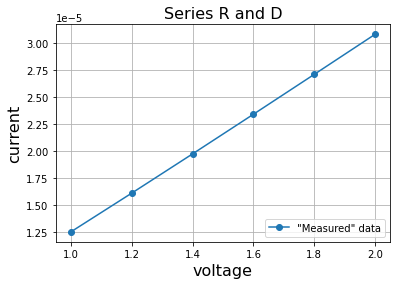

In [2]:
data = sr.read('diode.dat')
voltage = data['v(v-sweep)'][0]
current = data['i(@vsweep[i])'][0]

df = pd.DataFrame(
    data={
        "voltage": voltage,
        "current": -current,
    }
)
plt.plot(
    df['voltage'],
    df['current'],
    marker='o',
    label='"Measured" data'
);
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('voltage')
plt.ylabel('current')
plt.title('Series R and D');

In [3]:
def fn_thermal_voltage(TC):
    TK = convert_temperature(TC, 'C', 'K')
    return CONSTANTS.Boltzmann * TK / CONSTANTS.elementary_charge

def fn_voltage(i, R, VD0, n):
    return (
        i*R
        + VD0
        + n * fn_thermal_voltage(27) * np.log(i/i[0]))

def fn_voltage_res_only(i, R):
    return i*R

### Diode equation
\begin{align}
I &= I_S e^\frac{V_D}{n V_T}\\
V_D &= n V_T \ln{\frac{I}{I_S}}
\end{align}

### $IR$ and diode voltage drop

\begin{align}
V &= IR + V_{D0} + n V_T \ln{\frac{I}{I_0}}
\end{align}

### $IR$ voltage drop only

\begin{align}
V &= IR
\end{align}

'IR and diode voltage drop:'

{'R': 51996.22206964662, 'VD0': 0.3508954753639567, 'n': 2.0454941051023896}

'IR drop only:'

{'R': 68325.37535890758}

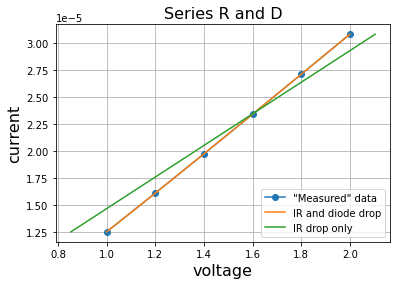

In [4]:
coeffs, cov = curve_fit(
    fn_voltage, df['current'], df['voltage'],
)
coeffs_res_only, cov_res_only = curve_fit(
    fn_voltage_res_only, df['current'], df['voltage'],
)

plt.plot(
    df['voltage'],
    df['current'],
    marker='o',
    label='"Measured" data',
);
plt.plot(
    fn_voltage(df['current'], *coeffs),
    df['current'],
    label='IR and diode drop',
)
plt.plot(
    fn_voltage_res_only(df['current'], *coeffs_res_only),
    df['current'],
    label='IR drop only',
)
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('voltage')
plt.ylabel('current')
plt.title('Series R and D')

display("IR and diode voltage drop:")
display(dict(zip(['R', 'VD0', 'n'],coeffs)))

display("IR drop only:")
display(dict(zip(['R'], coeffs_res_only)))

In [5]:
IS = df['current'].iloc[0] / (np.exp(coeffs[1]/coeffs[2]/fn_thermal_voltage(27)))

In [6]:
IS

1.6441585492762627e-08